In [144]:
from collections import Counter
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
trips = pd.read_csv('mrt_trips_sampled.csv')
trips['origin_tm'] = pd.to_timedelta(trips['origin_tm'])
trips['destination_tm'] = pd.to_timedelta(trips['destination_tm'])


In [3]:
trips['origin_cleaned'] = trips['origin'] \
                              .where(trips['origin'].str.istitle(), 
                                     other=trips['origin'].str.rsplit(n=1).map(lambda x: x[0]))
trips['destination_cleaned'] = trips['destination'] \
                                   .where(trips['destination'].str.istitle(), 
                                          other=trips['destination'].str.rsplit(n=1).map(lambda x: x[0]))


In [4]:
# Verify that cleaning works as expected
trips.loc[trips['origin'] != trips['origin_cleaned']][['origin', 'destination', 'origin_cleaned', 'destination_cleaned']]


,origin,destination,origin_cleaned,destination_cleaned
3,Bishan NSEW,Labrador Park,Bishan,Labrador Park
7,Chinatown NEL,Fernvale,Chinatown,Fernvale
8,Newton DTL,Clarke Quay,Newton,Clarke Quay
9,Tampines NSEW,Tanjong Pagar,Tampines,Tanjong Pagar
19,Newton NSEW,Orchard,Newton,Orchard
24,Newton DTL,Chinatown NEL,Newton,Chinatown
27,Serangoon NEL,Kent Ridge,Serangoon,Kent Ridge
33,Dhoby Ghaut NSEW,HarbourFront NEL,Dhoby Ghaut,HarbourFront
35,Chinatown NEL,Promenade,Chinatown,Promenade
39,Serangoon CCL,Buona Vista CCL,Serangoon,Buona Vista


In [5]:
# Validate origin-destination pair timings
trips.loc[trips['origin_tm'] >= trips['destination_tm']]


,index,destination,destination_tm,origin,origin_tm,origin_cleaned,destination_cleaned


In [6]:
min(trips['origin_tm']), max(trips['destination_tm'])



(Timedelta('0 days 09:00:00'), Timedelta('0 days 20:44:47'))

In [7]:
# Remove data where origin == destination, since it is useless for Task 1, 2, 3
trips = trips.loc[trips['origin_cleaned'] != trips['destination_cleaned']]


In [8]:
# Add a column duration (in mins) for easy calculation purposes
trips['duration'] = (trips['destination_tm'] - trips['origin_tm']) \
                        .map(lambda timedelta: timedelta.total_seconds())

min(trips['duration']), max(trips['duration'])


(20.0, 38736.0)

Since it doesn't make sense for duration to be as short as 20s and as long as 10h, we filter such that duration is between 3 minutes and 2 hours.


In [9]:
trips = trips \
            [(trips['duration'] >= 3 * 60) & (trips['duration'] <= 2 * 60 * 60)] \
            .sort_values('duration') \
            .drop_duplicates(subset=['destination', 'destination_tm', 'origin', 'origin_tm'])


In [10]:
impossible_trip = trips[(trips['origin'] == 'Sembawang') 
                      & (trips['destination'] == 'Expo NSEW') 
                      & (trips['duration'] < 600)]
print(impossible_trip)

# Remove this entry since this is practically impossible (and cannot be removed through automated means)
trips = trips.drop(impossible_trip.index)

# Verify removal of impossible trip
trips[(trips['origin'] == 'Sembawang') & (trips['destination'] == 'Expo NSEW')]



       index destination destination_tm     origin origin_tm origin_cleaned  \
43095  43095   Expo NSEW       09:27:57  Sembawang  09:22:46      Sembawang   

      destination_cleaned  duration  
43095                Expo     311.0  


,index,destination,destination_tm,origin,origin_tm,origin_cleaned,destination_cleaned,duration
334452,334452,Expo NSEW,10:36:01,Sembawang,09:34:33,Sembawang,Expo,3688.0
207475,207475,Expo NSEW,10:25:18,Sembawang,09:15:39,Sembawang,Expo,4179.0


In [11]:
trips = trips.drop(columns=['index'])
trips


,destination,destination_tm,origin,origin_tm,origin_cleaned,destination_cleaned,duration
181820,Orchard,09:59:59,Newton NSEW,09:56:59,Newton,Orchard,180.0
117936,Hougang,09:23:35,Kovan,09:20:35,Kovan,Hougang,180.0
50865,Buona Vista CCL,09:18:17,Holland Village,09:15:17,Holland Village,Buona Vista,180.0
333643,Orchard,09:36:01,Newton NSEW,09:33:01,Newton,Orchard,180.0
146487,Little India NEL,09:27:10,Farrer Park,09:24:10,Farrer Park,Little India,180.0
274959,Dhoby Ghaut NSEW,09:37:57,City Hall,09:34:57,City Hall,Dhoby Ghaut,180.0
52367,Raffles Place,09:26:12,Tanjong Pagar,09:23:12,Tanjong Pagar,Raffles Place,180.0
122050,Coral Edge,09:24:54,Meridian,09:21:54,Meridian,Coral Edge,180.0
346689,Teck Whye,09:04:33,Phoenix,09:01:33,Phoenix,Teck Whye,180.0
311407,one-north,09:08:07,Buona Vista CCL,09:05:06,Buona Vista,one-north,181.0


In [12]:
# Utility functions

def clean_station(name):
    return name.rsplit(' ', 1)[0] if name.split(' ')[-1].isupper() else name

def get_line_name(name):
    return name.rsplit(' ', 1)[-1] if name.split(' ')[-1].isupper() else 'Unknown'

print(clean_station('HarbourFront NEL'))
print(clean_station('Ang Mo Kio'))
print(clean_station('one-north'))
print(get_line_name('HarbourFront NEL'))
print(get_line_name('Ang Mo Kio'))
print(get_line_name('one-north'))


HarbourFront
Ang Mo Kio
one-north
NEL
Unknown
Unknown


# Task 1: Derive MRT network

In [102]:
# Use only the relevant subset of the full dataset
df1 = trips[['origin_cleaned', 'destination_cleaned', 'duration']]
df1 = df1[df1['duration'] <= 60 * 60]
df1 = df1[~df1['origin_cleaned'].isin(['Sam Kee', 'Nibong', 'Ten Mile Junction'])]
df1 = df1[~df1['destination_cleaned'].isin(['Sam Kee', 'Nibong', 'Ten Mile Junction'])]

all_stations = df1['origin_cleaned'] \
                   .append(df1['destination_cleaned'], ignore_index = True) \
                   .unique()
all_stations = all_stations[~pd.isnull(all_stations)]
all_stations, len(all_stations)


(array(['Newton', 'Kovan', 'Holland Village', 'Farrer Park', 'City Hall',
        'Tanjong Pagar', 'Meridian', 'Phoenix', 'Buona Vista', 'Chinatown',
        'Coral Edge', 'Ang Mo Kio', 'Outram Park', 'King Albert Park',
        'Kent Ridge', 'Toa Payoh', 'Telok Ayer', 'Mountbatten', 'Orchard',
        'Tai Seng', 'Novena', 'Pioneer', 'Boon Keng', 'Kadaloor',
        'Nicoll Highway', 'Little India', 'Hillview', 'Lorong Chuan',
        'Potong Pasir', 'MacPherson', 'Eunos', 'Queenstown', 'Bugis',
        'Somerset', 'Yew Tee', 'Clarke Quay', 'Braddell', 'Bakau', 'Senja',
        'Compassvale', 'Dhoby Ghaut', 'Rumbia', 'one-north', 'Riviera',
        'Woodleigh', 'Rochor', 'Khatib', 'Boon Lay', 'Bartley',
        'Paya Lebar', 'Bangkit', 'Chinese Garden', 'Commonwealth',
        'Hougang', 'Admiralty', 'Choa Chu Kang', 'Raffles Place', 'Dakota',
        'Buangkok', 'Telok Blangah', 'Cove', 'Bayfront', 'Caldecott',
        'Lavender', 'Kangkar', 'Kembangan', 'Serangoon', 'Promenade',
   

In [103]:
origin_destination_groups = df1.groupby(['origin_cleaned', 'destination_cleaned']).median()

origin_destination_groups


duration
origin_cleaned destination_cleaned          
Admiralty      Aljunied               3233.5
               Ang Mo Kio             1277.5
               Bartley                2098.0
               Bayfront               3261.0
               Bedok                  3416.5
               Bishan                 1538.0
               Boon Keng              2525.0
               Boon Lay               2297.5
               Botanic Gardens        2441.5
               Braddell               1709.0
               Bras Basah             2836.0
               Bugis                  2740.0
               Bukit Batok            1587.5
               Bukit Gombak           1421.5
               Bukit Panjang          1942.0
               Buona Vista            2638.0
               Caldecott              2575.0
               Chinatown              3004.0
               Chinese Garden         2630.0
               Choa Chu Kang          1249.5
               City Hall              2568.5
               Clarke Quay            2874.0
               Clementi               2235.5
               Commonwealth           2618.0
               Coral Edge             3254.0
               Dakota                 2870.0
               Dhoby Ghaut            2496.0
               Dover                  2404.0
               Esplanade              2964.0
               Eunos                  3092.5
...                                      ...
one-north      Kranji                 2128.0
               Labrador Park           721.0
               Little India           1620.0
               Lorong Chuan           1418.0
               MacPherson             2042.0
               Marina Bay             2028.0
               Marymount              1034.0
               Mountbatten            2319.0
               Nicoll Highway         2307.0
               Orchard                2159.0
               Outram Park            1294.0
               Pasir Panjang           484.0
               Paya Lebar             2127.0
               Promenade              1822.0
               Raffles Place          1584.0
               Rochor                 1494.0
               Sembawang              2485.0
               Serangoon              1529.0
               Stadium                2551.0
               Tai Seng               1809.0
               Tanah Merah            2961.0
               Tanjong Pagar          1488.5
               Telok Ayer             1740.0
               Telok Blangah           779.0
               Tiong Bahru            1116.0
               Toa Payoh              1726.0
               Woodlands              2328.0
               Woodleigh              1985.0
               Yio Chu Kang           3317.0
               Yishun                 2305.0

[8960 rows x 1 columns]

In [104]:
station_to_index = {}
for i, station in enumerate(all_stations):
    station_to_index[station] = i

dist_matrix = np.full((len(all_stations), len(all_stations)), 60 * 60, dtype=int)
for i in range(len(all_stations)):
    dist_matrix[i][i] = 0

for origin_dest, group in origin_destination_groups.iterrows():
    origin, dest = origin_dest
    duration = group.duration
    dist_matrix[station_to_index[origin]][station_to_index[dest]] = duration


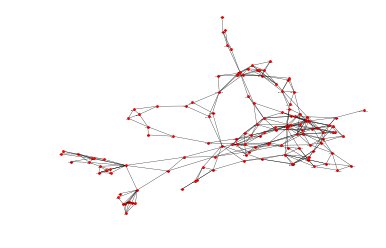

In [105]:
G = nx.from_numpy_matrix(dist_matrix)

bad_edges = [(u,v,d) for (u,v,d) in G.edges(data=True) if d['weight'] >= 600]

for (u,v,d) in bad_edges:
    G.remove_edge(u, v)

mapping = dict([(i,name) for i, name in enumerate(all_stations)])
G = nx.relabel_nodes(G, mapping, copy=False)
pos = nx.spring_layout(G)

# nx.draw(G, node_size=0.1, with_labels=True)
nx.draw_networkx(G, pos, width=0.3, font_size=1, node_size=3)
plt.axis('off')
plt.savefig("graph.png", dpi=1000)


This is a generic network, let's try adding more assumptions and incorporate our existing knowledge of the terminating stations.

To form a network, we can start by considering the two nearest neighbours from each origin.

#### Assumption: For each (station, neighbour_station) pair, there always exist a passenger that travels from/to station to/from neighbour_station.

In [118]:
df1 = trips[['origin', 'destination', 'duration']]
df1 = df1[df1['duration'] <= 60 * 60]

all_stations = df1['origin'] \
                   .append(df1['destination'], ignore_index = True) \
                   .unique()
all_stations = all_stations[~pd.isnull(all_stations)]
all_stations, len(all_stations)

(array(['Newton NSEW', 'Kovan', 'Holland Village', 'Farrer Park',
        'City Hall', 'Tanjong Pagar', 'Meridian', 'Phoenix',
        'Buona Vista CCL', 'Chinatown NEL', 'Coral Edge', 'Ang Mo Kio',
        'Outram Park NEL', 'Chinatown DTL', 'King Albert Park',
        'Kent Ridge', 'Toa Payoh', 'Telok Ayer', 'Mountbatten', 'Orchard',
        'Tai Seng', 'Novena', 'Pioneer', 'Boon Keng', 'Kadaloor',
        'Nicoll Highway', 'Little India NEL', 'Outram Park NSEW',
        'Hillview', 'Lorong Chuan', 'Potong Pasir', 'MacPherson CCL',
        'Eunos', 'Queenstown', 'Bugis NSEW', 'Somerset', 'Yew Tee',
        'Clarke Quay', 'Braddell', 'Bakau', 'Senja', 'Compassvale',
        'Dhoby Ghaut NSEW', 'Rumbia', 'one-north', 'Riviera', 'Woodleigh',
        'Rochor', 'Khatib', 'Boon Lay', 'Bartley', 'Paya Lebar CCL',
        'Bangkit', 'Chinese Garden', 'Commonwealth', 'Hougang',
        'Admiralty', 'Choa Chu Kang', 'Raffles Place', 'Dakota',
        'Buangkok', 'Telok Blangah', 'Cove', 'Bayfr

In [121]:
origin_destination_groups = df1.groupby(['origin', 'destination']).median()

origin_neighbours = {}

for station in all_stations:
    if station == 'Sam Kee': # Quick hack as there are no passenger that starts from Sam Kee station
        continue
    origin_neighbours[station] = origin_destination_groups \
                                     .loc[station] \
                                     .sort_values(['duration'])


In [123]:
def get_duration(origin, destination):
    return origin_neighbours[origin].loc[destination].duration

print(get_duration('Dhoby Ghaut NSEW', 'Ang Mo Kio'))


1142.5


In [124]:
start_stations = [('HarbourFront NEL', 'NEL'),
                  ('HarbourFront CCL', 'CCL'),
                  ('Pasir Ris', 'NSEW'),
                  ('Damai', 'PE'),
                  ('Cheng Lim', 'SW'),
                  ('Choa Chu Kang BPLRT', 'BPLRT'),
                  ('Dhoby Ghaut NSEW', 'NSEW'),
                  ('Bukit Panjang DTL', 'DTL'), # Everything after this line is just to include outliers
                  ('Chinatown DTL', 'DTL'),
                  ('Marina Bay CCL', 'CCL'),
                  ('Changi Airport', 'NSEW'),
                  ('Marina South Pier', 'NSEW'),
                  ('Ten Mile Junction', 'BPLRT'),
                  ('Nibong', 'PW')]


In [125]:
origin_neighbours_copy = {}

for key, value in origin_neighbours.copy().items():
    origin_neighbours_copy[key] = value.axes[0].values

THRESHOLD_DURATION = 600

visited = set()
for origin, line_name in start_stations:
    current_line_visited = set()
    print("Origin: {}".format(origin))
    current_station = origin
    mrt_line = []
    while current_station in origin_neighbours_copy:
        mrt_line.append(current_station)
        neighbour_stations = origin_neighbours_copy[current_station]
        del origin_neighbours_copy[current_station]
        visited.add(current_station)
        current_line_visited.add(clean_station(current_station))

        for neighbour in neighbour_stations:
            if not neighbour in visited \
                and not clean_station(neighbour) in current_line_visited \
                and get_line_name(neighbour) in [line_name, 'Unknown'] \
                and origin_neighbours[current_station].loc[neighbour].duration <= THRESHOLD_DURATION:
                current_station = neighbour
                break
    print('Number of stations: {}'.format(len(mrt_line)))
    print(mrt_line)
    print('\n')

print('Remaining Stations:')
origin_neighbours_copy.keys()

Origin: HarbourFront NEL
Number of stations: 20
['HarbourFront NEL', 'Outram Park NEL', 'Chinatown NEL', 'Clarke Quay', 'Dhoby Ghaut NEL', 'Little India NEL', 'Farrer Park', 'Boon Keng', 'Potong Pasir', 'Woodleigh', 'Serangoon NEL', 'Kovan', 'Hougang', 'Buangkok', 'Sengkang', 'Compassvale', 'Rumbia', 'Kangkar', 'Bakau', 'Ranggung']


Origin: HarbourFront CCL
Number of stations: 27
['HarbourFront CCL', 'Telok Blangah', 'Labrador Park', 'Pasir Panjang', 'Haw Par Villa', 'Kent Ridge', 'one-north', 'Buona Vista CCL', 'Holland Village', 'Farrer Road', 'Botanic Gardens CCL', 'Caldecott', 'Marymount', 'Bishan CCL', 'Lorong Chuan', 'Serangoon CCL', 'Bartley', 'Tai Seng', 'MacPherson CCL', 'Paya Lebar CCL', 'Dakota', 'Mountbatten', 'Stadium', 'Nicoll Highway', 'Promenade', 'Esplanade', 'Bras Basah']


Origin: Pasir Ris
Number of stations: 29
['Pasir Ris', 'Tampines NSEW', 'Simei', 'Tanah Merah', 'Bedok', 'Kembangan', 'Eunos', 'Paya Lebar NSEW', 'Aljunied', 'Kallang', 'Lavender', 'Bugis NSEW', '

dict_keys(['Bayfront DTL', 'Botanic Gardens DTL', 'Thanggam', 'Sumang'])

In [250]:
# Final answer
NEL_line = ['HarbourFront NEL',
            'Outram Park NEL',
            'Chinatown NEL',
            'Clarke Quay',
            'Dhoby Ghaut NEL',
            'Little India NEL',
            'Farrer Park',
            'Boon Keng',
            'Potong Pasir',
            'Woodleigh',
            'Serangoon NEL',
            'Kovan',
            'Hougang',
            'Buangkok',
            'Sengkang']


SE_line = ['Sengkang',
            'Compassvale',
            'Rumbia',
            'Kangkar', # Bakau should be before here...
            'Bakau',
            'Ranggung']

PE_line = ['Damai',
            'Oasis',
            'Kadaloor',
            'Riviera',
            'Coral Edge',
            'Meridian',
            'Cove',
            'Punggol']

CCL_line = ['HarbourFront CCL',
            'Telok Blangah',
            'Labrador Park',
            'Pasir Panjang',
            'Haw Par Villa',
            'Kent Ridge',
            'one-north',
            'Buona Vista CCL',
            'Holland Village',
            'Farrer Road',
            'Botanic Gardens CCL',
            'Caldecott',
            'Marymount',
            'Bishan CCL',
            'Lorong Chuan',
            'Serangoon CCL',
            'Bartley',
            'Tai Seng',
            'MacPherson CCL',
            'Paya Lebar CCL',
            'Dakota',
            'Mountbatten',
            'Stadium',
            'Nicoll Highway',
            'Promenade',
            'Esplanade',
            'Bras Besah']

EW_line = ['Pasir Ris',
            'Tampines NSEW',
            'Simei',
            'Tanah Merah',
            'Bedok',
            'Kembangan',
            'Eunos',
            'Paya Lebar NSEW',
            'Aljunied',
            'Kallang',
            'Lavender',
            'Bugis NSEW',
            'City Hall',
            'Raffles Place',
            'Tanjong Pagar',
            'Outram Park NSEW',
            'Tiong Bahru',
            'Redhill',
            'Queenstown',
            'Commonwealth',
            'Buona Vista NSEW',
            'Dover',
            'Clementi',
            'Jurong East',
            'Chinese Garden',
            'Lakeside',
            'Boon Lay',
            'Pioneer',
            'Joo Koon']

SW_line = ['Cheng Lim', 
           'Farmway', 
           'Kupang', 
           'Fernvale', 
           'Layar', 
           'Tongkang', 
           'Renjong']

BPLRT_line = ['Choa Chu Kang BPLRT', 
              'South View', 
              'Teck Whye', # Keat Hong should be before this...
              'Bukit Panjang BPLRT',  # Phoenix should be before this...
              'Phoenix', 
              'Keat Hong', 
              'Senja', 
              'Jelapang', 
              'Segar', 
              'Fajar', 
              'Bangkit', 
              'Pending', 
              'Petir']

NS_line = ['Dhoby Ghaut NSEW', 
           'Somerset', 
           'Orchard', 
           'Newton NSEW', 
           'Novena', 
           'Toa Payoh', 
           'Braddell', 
           'Bishan NSEW', 
           'Ang Mo Kio', 
           'Yio Chu Kang', 
           'Khatib', 
           'Yishun', 
           'Sembawang', 
           'Admiralty', 
           'Woodlands', 
           'Marsiling', 
           'Kranji', 
           'Yew Tee', 
           'Choa Chu Kang', 
           'Bukit Gombak', 
           'Bukit Batok']

DTL_line = ['Bukit Panjang DTL', 
            'Cashew', 
            'Hillview', 
            'Beauty World', 
            'King Albert Park', 
            'Sixth Avenue', 
            'Tan Kah Kee', 
            'Stevens', # Botanic Gardens DTL should be before this...
            'Newton DTL', 
            'Little India DTL', 
            'Bugis DTL', # Rochor should be before this...
            'Rochor']

# Task 2: Count trains that travel from station A to B

First, we modify the network from Task 1 to fit the actual network.

In [135]:
# Actual Lines
NEL_line = ['HarbourFront NEL',
            'Outram Park NEL',
            'Chinatown NEL',
            'Clarke Quay',
            'Dhoby Ghaut NEL',
            'Little India NEL',
            'Farrer Park',
            'Boon Keng',
            'Potong Pasir',
            'Woodleigh',
            'Serangoon NEL',
            'Kovan',
            'Hougang',
            'Buangkok',
            'Sengkang',
            'Punggol']

SE_line = ['Sengkang',
            'Compassvale',
            'Rumbia',
            'Bakau',
            'Kangkar',
            'Ranggung',
            'Sengkang']

PE_line = ['Punggol'
            'Damai',
            'Oasis',
            'Kadaloor',
            'Riviera',
            'Coral Edge',
            'Meridian',
            'Cove',
            'Punggol']

CCL_line = ['HarbourFront CCL',
            'Telok Blangah',
            'Labrador Park',
            'Pasir Panjang',
            'Haw Par Villa',
            'Kent Ridge',
            'one-north',
            'Buona Vista CCL',
            'Holland Village',
            'Farrer Road',
            'Botanic Gardens CCL',
            'Caldecott',
            'Marymount',
            'Bishan CCL',
            'Lorong Chuan',
            'Serangoon CCL',
            'Bartley',
            'Tai Seng',
            'MacPherson CCL',
            'Paya Lebar CCL',
            'Dakota',
            'Mountbatten',
            'Stadium',
            'Nicoll Highway',
            'Promenade',
            'Esplanade',
            'Bras Besah']

EW_line = ['Pasir Ris',
            'Tampines NSEW',
            'Simei',
            'Tanah Merah',
            'Bedok',
            'Kembangan',
            'Eunos',
            'Paya Lebar NSEW',
            'Aljunied',
            'Kallang',
            'Lavender',
            'Bugis NSEW',
            'City Hall',
            'Raffles Place',
            'Tanjong Pagar',
            'Outram Park NSEW',
            'Tiong Bahru',
            'Redhill',
            'Queenstown',
            'Commonwealth',
            'Buona Vista NSEW',
            'Dover',
            'Clementi',
            'Jurong East',
            'Chinese Garden',
            'Lakeside',
            'Boon Lay',
            'Pioneer',
            'Joo Koon']

SW_line = ['Sengkang'
           'Cheng Lim', 
           'Farmway', 
           'Kupang', 
           'Thanggam',
           'Fernvale', 
           'Layar', 
           'Tongkang', 
           'Renjong',
           'Sengkang']

BPLRT_line = ['Choa Chu Kang BPLRT', 
              'South View', 
              'Keat Hong',
              'Teck Whye',
              'Phoenix', 
              'Bukit Panjang BPLRT',
              'Senja', 
              'Jelapang', 
              'Segar', 
              'Fajar', 
              'Bangkit', 
              'Pending', 
              'Petir',
              'Bukit Panjang BPLRT']

NS_line = ['Marina South Pier', 
           'Marina Bay',
           'Raffles Place',
           'City Hall',
           'Dhoby Ghaut NSEW', 
           'Somerset', 
           'Orchard', 
           'Newton NSEW', 
           'Novena', 
           'Toa Payoh', 
           'Braddell', 
           'Bishan NSEW', 
           'Ang Mo Kio', 
           'Yio Chu Kang', 
           'Khatib', 
           'Yishun', 
           'Sembawang', 
           'Admiralty', 
           'Woodlands', 
           'Marsiling', 
           'Kranji', 
           'Yew Tee', 
           'Choa Chu Kang', 
           'Bukit Gombak', 
           'Bukit Batok',
           'Jurong East']

DTL_line = ['Bukit Panjang DTL', 
            'Cashew', 
            'Hillview', 
            'Beauty World', 
            'King Albert Park', 
            'Sixth Avenue', 
            'Tan Kah Kee', 
            'Botanic Gardens DTL',
            'Stevens',
            'Newton DTL', 
            'Little India DTL', 
            'Rochor',
            'Bugis DTL',
            'Promenade',
            'Bayfront DTL',
            'Downtown',
            'Telok Ayer',
            'Chinatown DTL']

PW_line = ['Punggol',
           'Soo Teck',
           'Sumang',
           'Nibong',
           'Samudera',
           'Punggol Point',
           'Teck Lee',
           'Sam Kee',
           'Punggol']

all_lines = [NEL_line, CCL_line, NS_line, EW_line, DTL_line,
             BPLRT_line, SE_line, PE_line, SW_line, PW_line]


In [136]:
# Use only the relevant parts of the full dataframe
df2 = trips[['origin', 'origin_tm', 'destination', 'destination_tm']]


We make some assumptions in order to answer this question.

1. Only consider destination time. Origin time is less accurate since the passenger might wait at the platform for quite long before the train arrives. Destination time is more accurate (lag by 1-2 minute) since users usually get out of the gantry as soon as they leave the train.

2. Between consecutive train arrivals, there is at least 1 minute delay. So we can consider the number of passenger tapping out of a gantry on a per-minute basis to simplify our calculations.

3. There can only be 1 possible direct path from origin to destination. Otherwise the "number of trains" question won't make sense.

In [137]:
def time_groups_to_timings(time_groups, group_len=60):
    return pd.to_timedelta([10**9 * time_group * group_len for time_group in time_groups])

print(time_groups_to_timings([0, 500, 501, 502, 503], 60))
print(time_groups_to_timings([0, 500, 501, 502, 503], 30))

TimedeltaIndex(['00:00:00', '08:20:00', '08:21:00', '08:22:00', '08:23:00'], dtype='timedelta64[ns]', freq=None)
TimedeltaIndex(['00:00:00', '04:10:00', '04:10:30', '04:11:00', '04:11:30'], dtype='timedelta64[ns]', freq=None)


In [138]:
def check_peaks(counts, threshold=0):
    return (counts - np.roll(counts,1) > threshold) & (counts - np.roll(counts,-1) > threshold)

def get_busy_plot(timings, group_len=60, threshold=0): # destination, group_len):
    timing_counter = Counter([i.total_seconds() // group_len for i in timings])
    time_group, frequency = list(timing_counter.keys()), list(timing_counter.values())
    timing = time_groups_to_timings(time_group, group_len)
    
    is_peak = check_peaks(frequency, threshold)
    peak_time = time_groups_to_timings([time_group[idx] for idx in is_peak.nonzero()[0]], group_len)
    peak_freq = [frequency[idx] for idx in is_peak.nonzero()[0]]
    plt.plot(timing, frequency)
    plt.plot(peak_time, peak_freq, 'ro')
    plt.xlabel('nanoseconds from 00:00:00')
    plt.ylabel('frequency')

def get_peak_timings(timings, group_len=60, threshold=0):
    timing_counter = Counter([i.total_seconds() // group_len for i in timings])
    time_group, frequency = list(timing_counter.keys()), list(timing_counter.values())
    
    is_peak = check_peaks(frequency, threshold)
    peak_time = [time_group[idx] for idx in is_peak.nonzero()[0]]
    return peak_time


In [139]:
def get_line_indexes(station):
    return {i for i, line in enumerate(all_lines) if station in line}

print("Raffles Place line indexes: {}".format(get_line_indexes('Raffles Place')))
print("Sengkang line indexes: {}".format(get_line_indexes('Sengkang')))
print("Lalaland line indexes: {}".format(get_line_indexes('Lalaland')))

def is_valid_pair(idx_A, idx_B, idx_X, idx_Y):
    return (idx_A <= idx_B and idx_X <= idx_Y) \
        or (idx_B <= idx_A and idx_Y <= idx_X)

def is_valid_station_pair(station_A, station_B, station_X, station_Y):
    subset_line_indexes = get_line_indexes(station_A).intersection(get_line_indexes(station_B))
    line_indexes = get_line_indexes(station_X).intersection(get_line_indexes(station_Y))
    
    valid_line_indexes = subset_line_indexes.intersection(line_indexes)
    if len(valid_line_indexes) != 1: # Consider only those with 1 possible line
        return False
    
    # Check if (station_A, station_B) and (station_X, station_Y) is in the same direction
    for line_index in valid_line_indexes:
        idx_A, idx_B = all_lines[line_index].index(station_A), all_lines[line_index].index(station_B)
        idx_X, idx_Y = all_lines[line_index].index(station_X), all_lines[line_index].index(station_Y)
        if is_valid_pair(idx_A, idx_B, idx_X, idx_Y):
            return True
    return False

print(is_valid_station_pair('City Hall', 'Raffles Place', 'Ang Mo Kio', 'Marina Bay'), True)
print(is_valid_station_pair('City Hall', 'Raffles Place', 'Marina Bay', 'Ang Mo Kio'), False)
print(is_valid_station_pair('Raffles Place', 'City Hall', 'Marina Bay', 'Ang Mo Kio'), True)
print(is_valid_station_pair('Raffles Place', 'City Hall', 'Ang Mo Kio', 'Marina Bay'), False)

def get_valid_station_pairs(station_A, station_B, series_X, series_Y):
    return [idx
            for idx, station_X, station_Y in zip(df2.index, df2['origin'], df2['destination']) \
            if is_valid_station_pair(station_A, station_B, station_X, station_Y)]

Raffles Place line indexes: {2, 3}
Sengkang line indexes: {0, 8, 6}
Lalaland line indexes: set()
True True
False False
True True
False False


{'Ang Mo Kio': 17, 'Yio Chu Kang': 12, 'Khatib': 15, 'Yishun': 20}

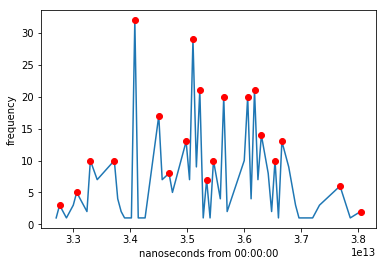

In [140]:
def count_trains(station_A, station_B):
    line_indexes = get_line_indexes(station_A).intersection(get_line_indexes(station_B))
    if len(line_indexes) != 1: # Consider only those with 1 possible line
        return -1
    
    line_idx = line_indexes.pop()
    station_A_idx = all_lines[line_idx].index(station_A)
    station_B_idx = all_lines[line_idx].index(station_B)
    range_i = list(range(station_A_idx, station_B_idx + 1)) if station_A_idx <= station_B_idx \
         else list(range(station_A_idx, station_B_idx - 1, -1))

    # Take all the valid station pairs
    valid_trips_idx = get_valid_station_pairs(station_A, station_B, df2['origin'], df2['destination'])
    valid_trips = df2.loc[valid_trips_idx]
    # print(valid_trips)
    
    # Then, count the number of unique trains based on the previous info obtained.
    # To do so, we need to find out at what time the train reach each station
    station_num_trains = {}
    for i in range_i:
        station_name = all_lines[line_idx][i]
        timings = list(valid_trips.loc[valid_trips['destination'] == station_name] \
                                  .sort_values('destination_tm') \
                                  .destination_tm)
        
        peak_time_groups = get_peak_timings(timings)
        station_num_trains[station_name] = len(peak_time_groups)
        #print("{}'s peak timings:".format(station_name))
        #print('Possible number of trains here: {}'.format(len(peak_time_groups)))
        #print(time_groups_to_timings(peak_time_groups))
        
    get_busy_plot(timings)
    return station_num_trains

# count_trains('Bartley', 'Farrer Road')
# print(count_trains('Bishan CCL', 'Kent Ridge'))
# print(count_trains('City Hall', 'Raffles Place'))
# print(count_trains('Kallang', 'Ang Mo Kio'))
# count_trains('Ang Mo Kio', 'Yio Chu Kang')
count_trains('Ang Mo Kio', 'Yishun')
# count_trains('Raffles Place', 'Yishun')
# count_trains('Marina Bay', 'Dhoby Ghaut NSEW')
# count_trains('Dhoby Ghaut NSEW', 'Ang Mo Kio')
# count_trains('Ang Mo Kio', 'Dhoby Ghaut NSEW')
# count_trains('Dhoby Ghaut NSEW', 'Dhoby Ghaut NSEW')

# Task 3: Count passengers at each station from station A to B

Assumptions:
1. MRT starts with 0 passengers and ends with 0 passengers.
2. To remove complication, assume interchange station works exactly just like any other stations.

In [154]:
df3 = trips[['destination', 'destination_tm', 'origin', 'origin_tm']].sort_values('origin_tm')


In [142]:
min(trips['origin_tm']), max(trips['destination_tm'])

(Timedelta('0 days 09:00:00'), Timedelta('0 days 11:53:51'))

In [161]:
def get_next_timing(timing, all_timings):
    next_timings = [t for t in all_timings if timing < t]
    if len(next_timings) > 0:
        return next_timings[0]
    return timing

def get_prev_timing(timing, all_timings):
    next_timings = [t for t in all_timings if timing > t]
    if len(next_timings) > 0:
        return next_timings[-1]
    return timing

In [193]:
def count_passengers(station_A, station_B, start_t):
    line_indexes = get_line_indexes(station_A).intersection(get_line_indexes(station_B))
    if len(line_indexes) != 1: # Consider only those with 1 possible line
        return -1
    
    t = datetime.strptime(start_t, "%H:%M:%S")
    start_t = timedelta(hours=t.hour, minutes=t.minute, seconds=t.second)
    
    line_idx = line_indexes.pop()
    station_A_idx = all_lines[line_idx].index(station_A)
    station_B_idx = all_lines[line_idx].index(station_B)
    range_i = list(range(station_A_idx, len(all_lines[line_idx]))) if station_A_idx <= station_B_idx \
         else list(range(station_A_idx, -1, -1))

    # Take all the valid station pairs
    valid_trips_idx = get_valid_station_pairs(station_A, station_B, df2['origin'], df2['destination'])
    valid_trips = df2.loc[valid_trips_idx]
    
    # Main algorithm
    station_time_num_passengers = []
    curr_time = start_t
    for i in range_i:
        station_name = all_lines[line_idx][i]
        timings = list(valid_trips.loc[valid_trips['destination'] == station_name] \
                                  .sort_values('destination_tm') \
                                  .destination_tm)
        peak_time_groups = get_peak_timings(timings)
        peak_timings = time_groups_to_timings(peak_time_groups)
        curr_time = get_next_timing(curr_time, peak_timings)
        station_time_num_passengers.append([station_name, curr_time, 0, peak_timings])
        #print("{}'s peak timings:".format(station_name))
        #print('Possible number of trains here: {}'.format(len(peak_time_groups)))
        #print(peak_timings)
    
    # Work backwards, number of destination at the last station = number of passengers at the second last station.
    station_time_num_passengers.reverse()
    station_time_num_passengers[0][2] = 0 # Destination station should have 0 passengers
    prev_time = get_prev_timing(curr_time, peak_timings)
    num_passengers_departed = len(valid_trips.loc[(valid_trips['destination'] == station_time_num_passengers[0][0])
                                                & (valid_trips['destination_tm'] >= prev_time)
                                                & (valid_trips['destination_tm'] < curr_time)])
    num_passengers_arrived = 0
    for i in range(1, len(station_time_num_passengers)):
        # print(station_time_num_passengers[i][0])
        station_time_num_passengers[i][2] += station_time_num_passengers[i-1][2] + num_passengers_departed - num_passengers_arrived
        curr_time = station_time_num_passengers[i][1]
        peak_timings = station_time_num_passengers[i][3]
        prev_time = get_prev_timing(curr_time, peak_timings)
        num_passengers_departed = len(valid_trips.loc[(valid_trips['destination'] == station_time_num_passengers[i][0])
                                                    & (valid_trips['destination_tm'] >= prev_time)
                                                    & (valid_trips['destination_tm'] < curr_time)])
        num_passengers_arrived = len(valid_trips.loc[(valid_trips['origin'] == station_time_num_passengers[i][0])
                                                    & (valid_trips['origin_tm'] >= prev_time)
                                                    & (valid_trips['origin_tm'] < curr_time)])
        
    station_time_num_passengers.reverse()
    result = [[name, time, num_passengers] for name, time, num_passengers, peak_timings in station_time_num_passengers]
    return pd.DataFrame(result[:abs(station_A_idx - station_B_idx)+1], 
                        columns=['station', 'arrival_time', 'num_passengers'])

# count_passengers('Ang Mo Kio', 'Woodlands', '09:30:00')
# count_passengers('Bishan NSEW', 'Woodlands', '09:30:00')
# count_passengers('Woodlands', 'Khatib', '09:30:00')
count_passengers('Clementi', 'Kallang', '09:25:00')


,station,arrival_time,num_passengers
0,Clementi,09:27:00,316
1,Dover,09:30:00,321
2,Buona Vista NSEW,09:32:00,314
3,Commonwealth,09:34:00,322
4,Queenstown,09:38:00,359
5,Redhill,09:39:00,361
6,Tiong Bahru,09:56:00,457
7,Outram Park NSEW,10:02:00,401
8,Tanjong Pagar,10:04:00,354
9,Raffles Place,10:06:00,286
